In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector   
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
module = fc.eightb.preselection.t8btag_minmass

In [3]:
signal = ObjIter([Tree(f, report=False) for f in tqdm(module.signal_list)])
bkg = ObjIter([Tree(module.Run2_UL18.QCD_B_List)])

100%|██████████| 16/16 [00:11<00:00,  1.41it/s]


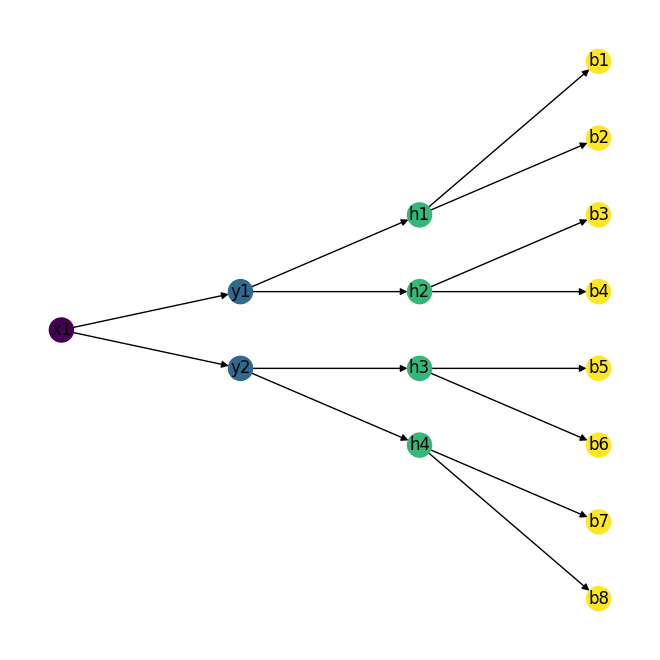

In [4]:
from utils.FeynNet.Feynman import Feynman

x_yy_4h_8b = Feynman('x').decays(
    Feynman('y').decays(
        Feynman('h').decays('b','b'),
        Feynman('h').decays('b','b')
    ),
    Feynman('y').decays(
        Feynman('h').decays('b','b'),
        Feynman('h').decays('b','b')
    )
).build_diagram()
x_yy_4h_8b.draw_diagram()

In [25]:
model = '/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models/exp_feynnet_paper/feynnet_8b/20230326_ranger_lr0.0047_batch1024_withbkg'

(signal + bkg).apply( lambda t : eightb.load_yy_quadh_ranker(t, model, extra=['mass_rank']), report=True )

100%|██████████| 4/4 [00:20<00:00,  5.16s/it]


[None, None, None, None]

In [29]:
bkg.feynnet_mass_rank

[<Array [[0.938, 0.925, 1.01, ... 0.969, 0.99]] type='103667 * var * float64'>]

100%|██████████| 1/1 [00:14<00:00, 14.93s/it]


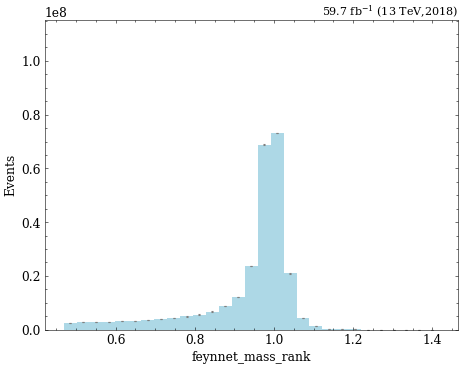

In [27]:
study.quick(
    bkg,
    varlist=['feynnet_mass_rank'],
    binlist=[()]
)

In [6]:
def fully_reconstructed(t):
            h_b_ids = [ t[f'{quark}_signalId'] // 2 for quark in eightb.quarklist ]
            y_h_ids = [ ak.where(h_b1_id == h_b2_id, h_b1_id, -1) // 2 for h_b1_id, h_b2_id in zip(h_b_ids[::2], h_b_ids[1::2]) ]
            y1_id, y2_id = [ ak.where(y_h1_id == y_h2_id, y_h1_id, -1) // 2 for y_h1_id, y_h2_id in zip(y_h_ids[::2], y_h_ids[1::2]) ]
            reco_id = ak.where(y1_id == y2_id, y1_id, -1)
            t.extend(
                reco_id = reco_id
            )
(signal).apply(fully_reconstructed)

[None, None, None]

100%|██████████| 1/1 [00:06<00:00,  6.32s/it]


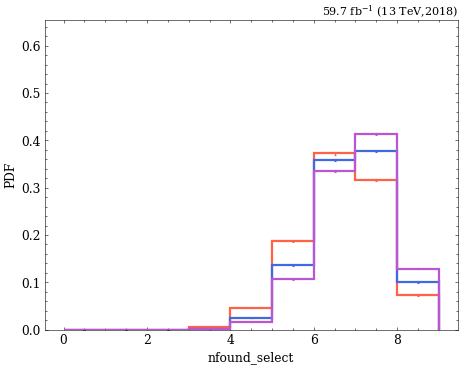

In [7]:
study.quick(
    signal,
    varlist=['nfound_select'],
    efficiency=True,
    
)

In [8]:
eightb_signal = signal.apply(EventFilter('all_eightb', filter=lambda t : t.nfound_select==8))


100%|██████████| 1/1 [00:04<00:00,  4.84s/it]


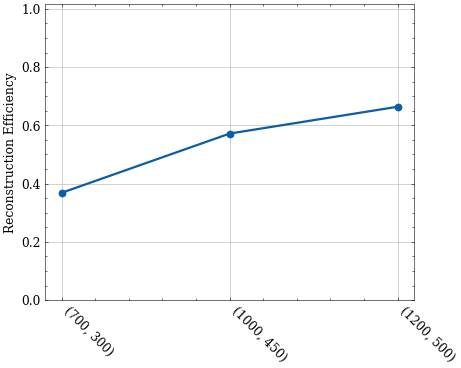

In [9]:
study.statsplot(
    eightb_signal,
    label=signal.mass.list,
    varlist=['reco_id'],
    xlabels=['Reconstruction Efficiency'],
    efficiency=True,

    stat=lambda h:h.histo[-1],
    g_grid=True,

)

100%|██████████| 2/2 [00:04<00:00,  2.16s/it]


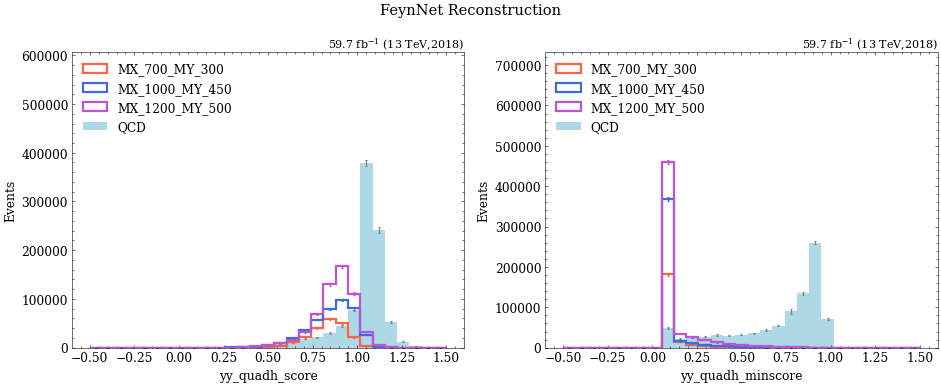

In [10]:
study.quick(
    eightb_signal+bkg,
    legend=True,
    h_label_stat=None,
    scale=[1000]*len(signal),
    varlist=['yy_quadh_score','yy_quadh_minscore'],
    binlist=[(-0.5,1.5,30)]*2,
    suptitle='FeynNet Reconstruction',
    # efficiency=True,
    # **study.auroc,
)

In [11]:
varinfo.X_m =   dict(bins=(400,2000,30), xlabel='$M_{X}$ (GeV)')
varinfo.Y1_m =  dict(bins=(100,1000,30), xlabel='$M_{Y1}$ (GeV)')
varinfo.Y2_m =  dict(bins=(100,1000,30), xlabel='$M_{Y2}$ (GeV)')
varinfo.H1Y1_m =   dict(bins=(0,300,30), xlabel='$M_{H1Y1}$ (GeV)')
varinfo.H2Y1_m =   dict(bins=(0,300,30), xlabel='$M_{H2Y1}$ (GeV)')
varinfo.H1Y2_m =   dict(bins=(0,300,30), xlabel='$M_{H1Y2}$ (GeV)')
varinfo.H2Y2_m =   dict(bins=(0,300,30), xlabel='$M_{H2Y2}$ (GeV)')


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


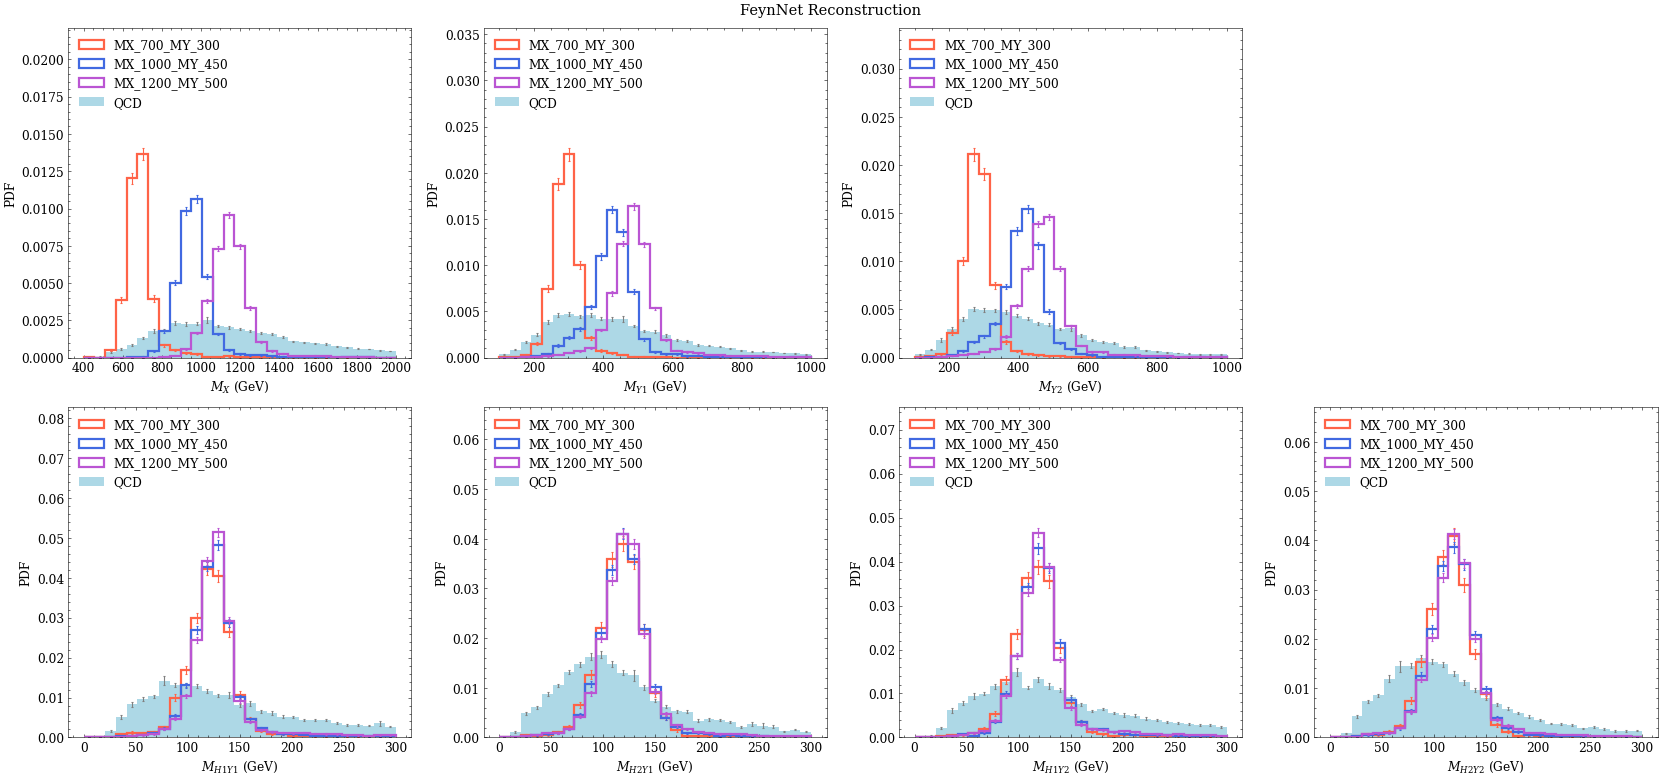

In [12]:
study.quick(
    eightb_signal+bkg,
    legend=True,
    h_label_stat=None,
    varlist=['X_m','Y1_m','Y2_m',None,'H1Y1_m','H2Y1_m','H1Y2_m','H2Y2_m'],
    suptitle='FeynNet Reconstruction',
    lumi=None,
    density=True,
)